In [2]:

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from IPython.display import display, clear_output
from matplotlib import animation, rc
from IPython.display import HTML
from sklearn.decomposition import FactorAnalysis, PCA, MiniBatchDictionaryLearning
import requests
import pickle, gzip, numpy

%matplotlib inline
#%matplotlib notebook
    
def plot_im_array2(X,S,N,A,title):    
    I = np.ones(((A*(1+S),A*(1+S))))*max(X.flatten())
    k=0
    for i in range(A):
        for j in range(A):
            I[i*(S)+i:(i+1)*S+i,j*S+j:(j+1)*S+j] = X[k,:].reshape((S, S))
            k=k+1
            if(k==N): break
        if(k==N): break
            
    plt.imshow(I, cmap=plt.cm.gray,interpolation=None)
    plt.colorbar()
    plt.xticks(())
    plt.yticks(())
    plt.title(title)
    

In [3]:
# Get Data
r = requests.get('https://s3.amazonaws.com/img-datasets/mnist.pkl.gz')
with open('mnist.pkl.gz', 'wb') as f:
    f.write(r.content)

In [3]:
#Load Data
f = gzip.open('mnist.pkl.gz', 'rb')
train_set, test_set = pickle.load(f,encoding='latin1')

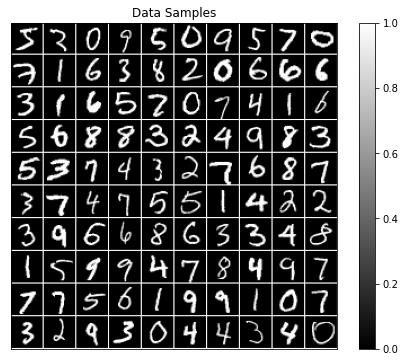

In [4]:
#Show data
X = train_set[0]/256.0
X = X.reshape(X.shape[0],X.shape[1]*X.shape[2])
plt.figure(figsize=[8,6]);
plot_im_array2(X[range(0,50000,500),:],28,100,10,"Data Samples")
plt.clim(0,1)
plt.show()

Y = train_set[1]

Mixture Models
===

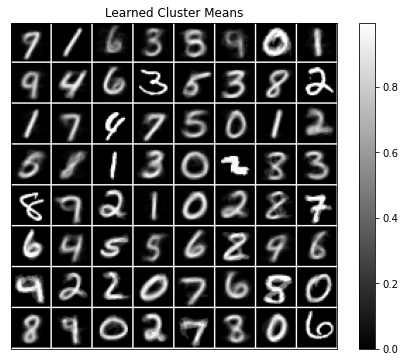

In [92]:
from sklearn.cluster import MiniBatchKMeans
from scipy.special import logsumexp
KM=MiniBatchKMeans(n_clusters=64, max_iter=100, batch_size=100, verbose=0)
KM.fit(X)
ms = KM.cluster_centers_ 

plt.figure(1,figsize=[8,6])
plot_im_array2(ms,28,64,8,"Learned Cluster Means")
plt.show()

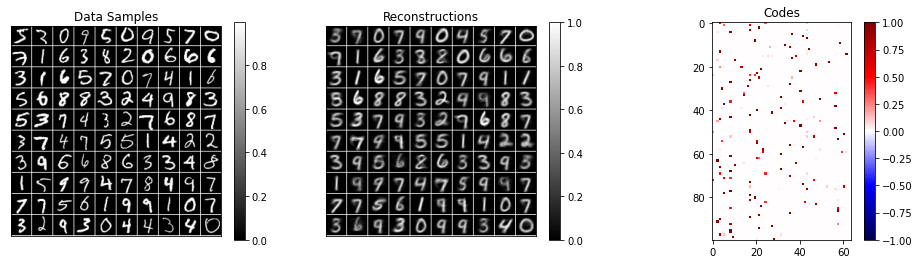

In [98]:
def reconstruct(Z,mu):
    return(Z.dot(mu))

#Set noise
noise_std=0

Xsub = X[range(0,50000,500),:]
Xsub = np.minimum(1,np.maximum(0,Xsub + noise_std*np.random.randn(*Xsub.shape)))

D    = 10*KM.transform(Xsub)
Z    = np.exp(-D - logsumexp(-D,axis=1,keepdims=True))
XR   = reconstruct(Z,ms)

plt.figure(1,figsize=[16,4])
plt.subplot(1,3,1)
plot_im_array2(Xsub,28,100,10,"Data Samples")

plt.subplot(1,3,2)
plot_im_array2(XR,28,100,10,"Reconstructions")
plt.clim(0,1)

plt.subplot(1,3,3)
plt.title("Codes")
plt.imshow(Z,cmap=plt.get_cmap('seismic'),interpolation="nearest")
plt.colorbar()
plt.clim(-1,1)

Factor Analysis
===

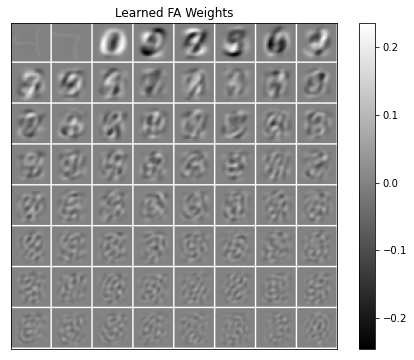

In [55]:
FA = FactorAnalysis(n_components=64, tol=0.01, copy=True, max_iter=100, random_state=0)
FA.fit(X[:5000,:])
Wf=FA.components_
mu = FA.mean_

plt.figure(1,figsize=[8,6])
plot_im_array2(Wf,28,64,8,"Learned FA Weights")
plt.show()


In [ ]:
def generate(Z,W,mu):
    return(Z.dot(W) + mu)

z = np.array([[0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0]]).flatten()

x = generate(z,Wf,mu).reshape(28,28)
plt.imshow(x,cmap=plt.cm.gray,interpolation=None)
plt.show()

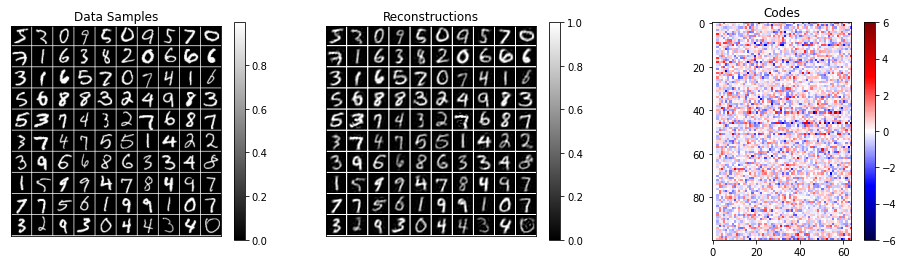

In [61]:
def reconstruct(Z,W,mu):
    return(Z.dot(W) + mu)

#Set noise
noise_std=0

Xsub = X[range(0,50000,500),:]
Xsub = np.minimum(1,np.maximum(0,Xsub + noise_std*np.random.randn(*Xsub.shape)))

Z    = FA.transform(Xsub)
XR   = reconstruct(Z,Wf,mu)

plt.figure(1,figsize=[16,4])
plt.subplot(1,3,1)
plot_im_array2(Xsub,28,100,10,"Data Samples")

plt.subplot(1,3,2)
plot_im_array2(XR,28,100,10,"Reconstructions")
plt.clim(0,1)

plt.subplot(1,3,3)
plt.title("Codes")
plt.imshow(Z,cmap=plt.get_cmap('seismic'),interpolation="nearest")
plt.colorbar()
plt.clim(-6,6)


# PCA

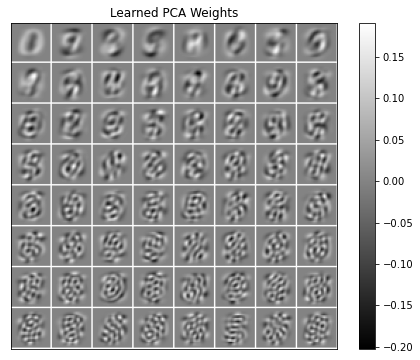

In [62]:
pca = PCA(n_components=64, tol=0.01, copy=True, random_state=0)
pca.fit(X)

Wf=pca.components_
mu = pca.mean_

plt.figure(1,figsize=[8,6])
plot_im_array2(Wf,28,64,8,"Learned PCA Weights")
plt.show()

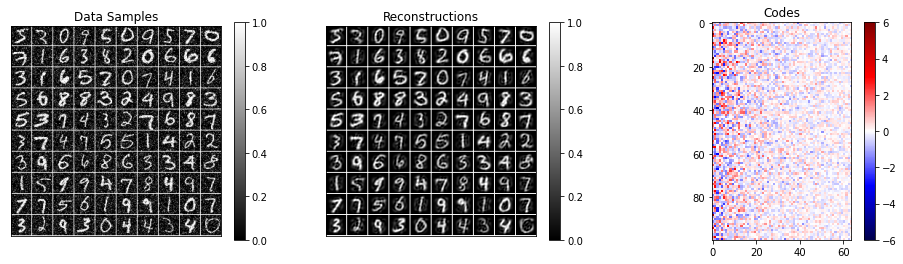

In [64]:
def reconstruct(Z,W,mu):
    return(Z.dot(W) + mu)

#Set noise
noise_std=0

Xsub = X[range(0,50000,500),:]
Xsub = np.minimum(1,np.maximum(0,Xsub + noise_std*np.random.randn(*Xsub.shape)))

Z    = pca.transform(Xsub)
XR   = reconstruct(Z,Wf,mu)

plt.figure(1,figsize=[16,4])
plt.subplot(1,3,1)
plot_im_array2(Xsub,28,100,10,"Data Samples")

plt.subplot(1,3,2)
plot_im_array2(XR,28,100,10,"Reconstructions")
plt.clim(0,1)

plt.subplot(1,3,3)
plt.title("Codes")
plt.imshow(Z,cmap=plt.get_cmap('seismic'),interpolation="nearest")
plt.colorbar()
plt.clim(-6,6)

# Sparse Coding

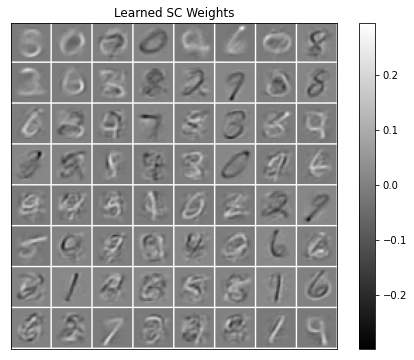

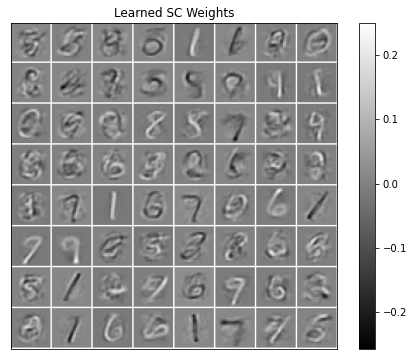

In [86]:
sc = MiniBatchDictionaryLearning(n_components=128, alpha=0.1, batch_size=10, transform_n_nonzero_coefs=64, n_iter=1000, random_state=0)
sc.fit(X[:5000,:] - np.mean(X))

Wf=sc.components_
mu = np.mean(X)

plt.figure(1,figsize=[8,6])
plot_im_array2(Wf[:64,:],28,64,8,"Learned SC Weights")

plt.figure(2,figsize=[8,6])
plot_im_array2(Wf[64:,:],28,64,8,"Learned SC Weights")


plt.show()

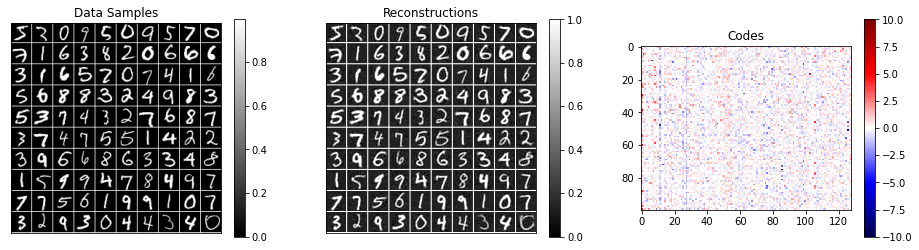

In [90]:
def reconstruct(Z,W,mu):
    return(Z.dot(W) + mu)

#Set noise
noise_std=0

Xsub = X[range(0,50000,500),:]
Xsub = np.minimum(1,np.maximum(0,Xsub + noise_std*np.random.randn(*Xsub.shape)))

Z    = sc.transform(Xsub)
XR   = reconstruct(Z,Wf,mu)

plt.figure(1,figsize=[16,4])
plt.subplot(1,3,1)
plot_im_array2(Xsub,28,100,10,"Data Samples")

plt.subplot(1,3,2)
plot_im_array2(XR,28,100,10,"Reconstructions")
plt.clim(0,1)

plt.subplot(1,3,3)
plt.title("Codes")
plt.imshow(Z,cmap=plt.get_cmap('seismic'),interpolation="nearest")
plt.colorbar()
plt.clim(-10,10)

## 2D Factor Analysis

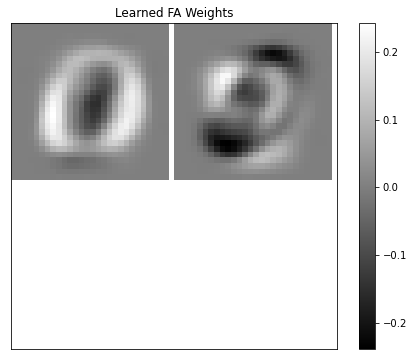

In [5]:
FA = FactorAnalysis(n_components=2, tol=0.01, copy=True, max_iter=100, random_state=0)
FA.fit(X[:5000,:])
Wf=FA.components_
mu = FA.mean_

plt.figure(1,figsize=[8,6])
plot_im_array2(Wf,28,2,2,"Learned FA Weights")
plt.show()

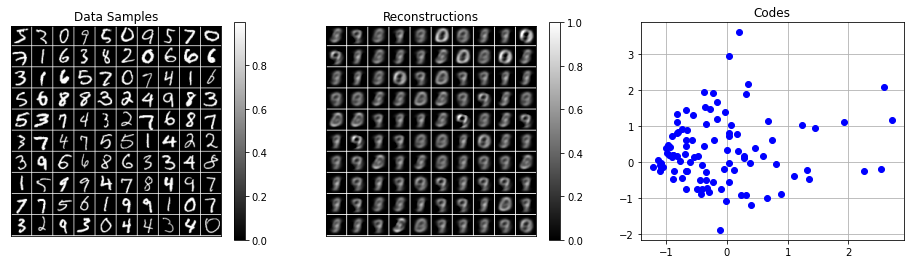

In [13]:
def reconstruct(Z,W,mu):
    return(Z.dot(W) + mu)

#Set noise
noise_std=0

Xsub = X[range(0,50000,500),:]
Xsub = np.minimum(1,np.maximum(0,Xsub + noise_std*np.random.randn(*Xsub.shape)))

Z    = FA.transform(Xsub)
XR   = reconstruct(Z,Wf,mu)

plt.figure(1,figsize=[16,4])
plt.subplot(1,3,1)
plot_im_array2(Xsub,28,100,10,"Data Samples")

plt.subplot(1,3,2)
plot_im_array2(XR,28,100,10,"Reconstructions")
plt.clim(0,1)

plt.subplot(1,3,3)
plt.title("Codes")
plt.plot(Z[:,0],Z[:,1],'bo',alpha=1)
plt.grid(True)

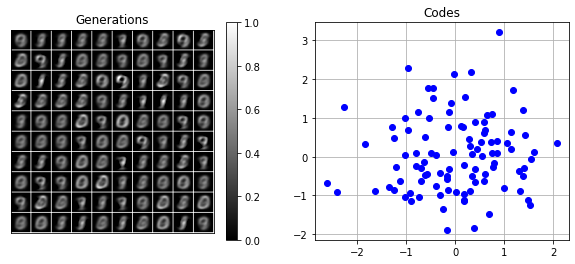

In [16]:
Z = np.random.randn(100,2)
XR   = reconstruct(Z,Wf,mu)

plt.figure(1,figsize=[10,4])
plt.subplot(1,2,1)
plot_im_array2(XR,28,100,10,"Generations")
plt.clim(0,1)

plt.subplot(1,2,2)
plt.title("Codes")
plt.plot(Z[:,0],Z[:,1],'bo',alpha=1)
plt.grid(True)

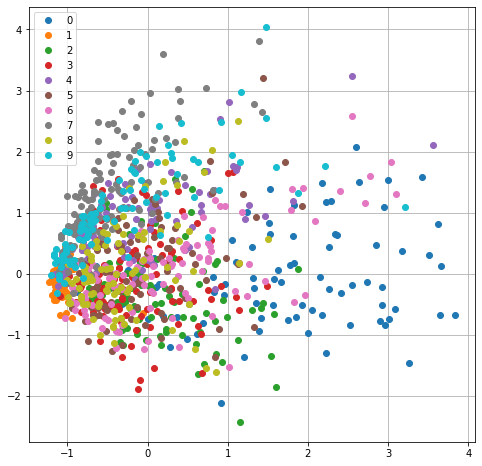

In [25]:
Xsub = X[range(0,50000,50),:]
Ysub = Y[range(0,50000,50)]

Z    = FA.transform(Xsub)
XR   = reconstruct(Z,Wf,mu)

plt.figure(figsize=(8,8))
for c in range(10):
    plt.plot(Z[Ysub==c,0],Z[Ysub==c,1],'o', label="%d"%c,alpha=1)
plt.legend()
plt.grid(True)